## A New Data Approach in Time Series

Time Series data is a sequence of data points indexed in time order. The most common example of time series data is the daily closing price of the stock market. Beside the stock market, we do encounter a lot of different time series data, for instance, the climate changes across time or the sales revenue of a company. Time series analysis helps organizations understand the underlying causes of trends or systemic patterns over time.

Today, we want to dive into a fancy and powerful time series data structure engine.

[__Time-Series-Transformer__](https://pypi.org/project/time-series-transform/)

The package not only provides functionalities to process the time series data, but it shines when we need to process __multi-dimensional__ time series data. Moreover, the submodule, __Stock_Transformer__, is able to simply extract the stock data in one lines of code.

### Installation

```
pip install time-series-transform
```

_Note: Make sure tensorflow and plotly are installed on your machine_

### Data

In this example, we will use the climate time series data in Delhi from Kaggle

https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?resource=download

## Time Series Transformer Core

__Time_Series_Transformer__ helps us to format the time series data and we are able to manipulate the time series data easily.

In [70]:
import pandas as pd
import numpy as np
from time_series_transform import Time_Series_Transformer
from time_series_transform import Stock_Transformer
from time_series_transform.transform_core_api.util import moving_average, rfft_transform, madev, wavelet_denoising, differencing, ema, geometric_ma

In [71]:
df = pd.read_csv('data/DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [72]:
# load the data to Time_Series_Transformer from pandas dataframe
tst_data = Time_Series_Transformer.from_pandas(pandasFrame = df, timeSeriesCol = 'date', mainCategoryCol = None)
time_series_data = tst_data.time_series_data

print(f'Time_Series_Transformer data')
print(tst_data)
print(f'We can slice the data from the time_series_data as below')
time_series_data[:3]

Time_Series_Transformer data
data column
-----------
date
meantemp
humidity
wind_speed
meanpressure
time length: 1462
category: None


We can slice the data from the time_series_data as below


{'date': array(['2013-01-01', '2013-01-02', '2013-01-03'], dtype=object),
 'meantemp': array([10.        ,  7.4       ,  7.16666667]),
 'humidity': array([84.5, 92. , 87. ]),
 'wind_speed': array([0.        , 2.98      , 4.63333333]),
 'meanpressure': array([1015.66666667, 1017.8       , 1018.66666667])}

### Data Manipulation

Most of the time, we need to preprocess the data before entering the model. In time series analysis, making lag or lead data (shifting data) is one of the most common methods. The package also provide the function to shift data.

- make_lead
- make_lag
- make_lead_sequence
- make_lag_sequence

_make_lead_ and _make_lag_ shift the data

_make_lead_sequence_ and _make_lag_sequence_ shift the data and return a window list data as feature. It is useful in Deep learning feature

In [73]:
tst_data.make_lead(
    inputLabels = ['meantemp', 'wind_speed'],
    leadNum = 3,
    suffix = '_lead_',
    fillMissing = np.nan
)
tst_data

data column
-----------
date
meantemp
humidity
wind_speed
meanpressure
meantemp_lead_3
wind_speed_lead_3
time length: 1462
category: None


In [74]:
# To visualize the data shifting, we use pandas. We can use the to_pandas() to get the dataframe
tst_data.to_pandas().head()

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_lead_3,wind_speed_lead_3
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,8.666667,1.233333
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,6.000000,3.700000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,7.000000,1.480000
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.000000,6.300000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.857143,7.142857


In [75]:
tst_data.make_lead_sequence(
    inputLabels = ['meantemp', 'meanpressure'],
    windowSize = 3,
    leadNum = 1,
    suffix = '_lead_seq_',
    fillMissing = np.nan
)

time_series_data[:3]

{'date': array(['2013-01-01', '2013-01-02', '2013-01-03'], dtype=object),
 'meantemp': array([10.        ,  7.4       ,  7.16666667]),
 'humidity': array([84.5, 92. , 87. ]),
 'wind_speed': array([0.        , 2.98      , 4.63333333]),
 'meanpressure': array([1015.66666667, 1017.8       , 1018.66666667]),
 'meantemp_lead_3': array([8.66666667, 6.        , 7.        ]),
 'wind_speed_lead_3': array([1.23333333, 3.7       , 1.48      ]),
 'meantemp_lead_seq_3': array([[7.4       , 7.16666667, 8.66666667],
        [7.16666667, 8.66666667, 6.        ],
        [8.66666667, 6.        , 7.        ]]),
 'meanpressure_lead_seq_3': array([[1017.8       , 1018.66666667, 1017.16666667],
        [1018.66666667, 1017.16666667, 1016.5       ],
        [1017.16666667, 1016.5       , 1018.        ]])}

### Custom function 

We can use the __transform__ function to customize the data process.

Restriction of the customize function:
- the function must take an array
- output must be an array with the same size as the original data length

Note: time_series_transform.transform_core_api.util provides some general functions as we imported at the beginning

In [76]:
def customize_function(arr, add_val = 3):
    # this function add add_val to all of the values in the array
    return [item + add_val for item in arr]

tst_data.transform("wind_speed","wind_cust_10", customize_function, add_val=10)

data column
-----------
date
meantemp
humidity
wind_speed
meanpressure
meantemp_lead_3
wind_speed_lead_3
meantemp_lead_seq_3
meanpressure_lead_seq_3
wind_cust_10
time length: 1462
category: None


## Plot

The package also provides function to draw plot and it supports several functions for the plot.
- add_line
- remove_line
- update_layout
- add_marker



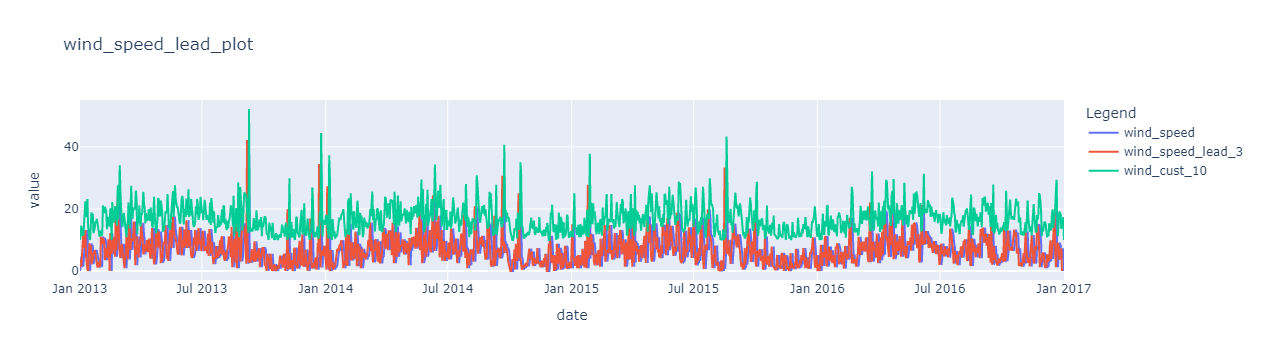

In [77]:
fig = tst_data.plot(cols = ['wind_speed', 'wind_speed_lead_3', 'wind_cust_10'], 
                    title = 'wind_speed_lead_plot', 
                    type = 'scatter')
fig.show()

### Multi-Dimensional Time Series Data

Sometimes when we are doing Exploratory Data Analysis or preprocessing the time series data before entering the model, we might want to separate the data by their features. Handling multi-dimensional time series data is the strong point of the package. For example, we want to separate the data by their month and investigate the behavior of the data.

Time_Series_Transformer can specify the __mainCategoryCol__ parameter to point out the main category. This class only provide one columns for main category because multiple dimensions can be aggregated into a new column as main category.

To demonstrate the capability of the __Time_Series_Transformer__, we first need to tag the data by their month, and we can use the package to do the data operation.

In [138]:
# first we extract the month value
df['month'] = df['date'].str[5:7]
df['time_id'] = df['date'].str[3] + df['date'].str[8:]
df.head()

,date,meantemp,humidity,wind_speed,meanpressure,month,time_id
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,01,301
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,01,302
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,01,303
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,01,304
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,01,305


In [139]:
tst_data = Time_Series_Transformer.from_pandas(pandasFrame = df, 
                                               timeSeriesCol = 'time_id', 
                                               mainCategoryCol = 'month')


The time series data become a dictionary-like data where _key=mainCategoryCol_, and the data manipulation functions will apply to all data corresponding to their category.

In [140]:
tst_data.make_lead(
    inputLabels = ['meantemp', 'wind_speed'],
    leadNum = 3,
    suffix = '_lead_',
    fillMissing = np.nan
)

tst_data.time_series_data['10'][:5]

{'time_id': array(['301', '302', '303', '304', '305'], dtype=object),
 'date': array(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04',
        '2013-10-05'], dtype=object),
 'meantemp': array([28.28571429, 29.2       , 28.6       , 24.83333333, 28.5       ]),
 'humidity': array([68.71428571, 61.4       , 59.        , 84.33333333, 69.        ]),
 'wind_speed': array([6.37142857, 7.42      , 7.4       , 6.78333333, 2.0875    ]),
 'meanpressure': array([1007.71428571, 1010.        , 1008.6       , 1007.5       ,
        1004.125     ]),
 'meantemp_lead_3': array([24.83333333, 28.5       , 29.75      , 29.71428571, 29.2       ]),
 'wind_speed_lead_3': array([6.78333333, 2.0875    , 1.85      , 1.58571429, 0.        ])}

In [141]:
fig = tst_data.plot(cols = ['wind_speed'], 
                    title = 'wind_speed_lead_plot', 
                    type = 'scatter')

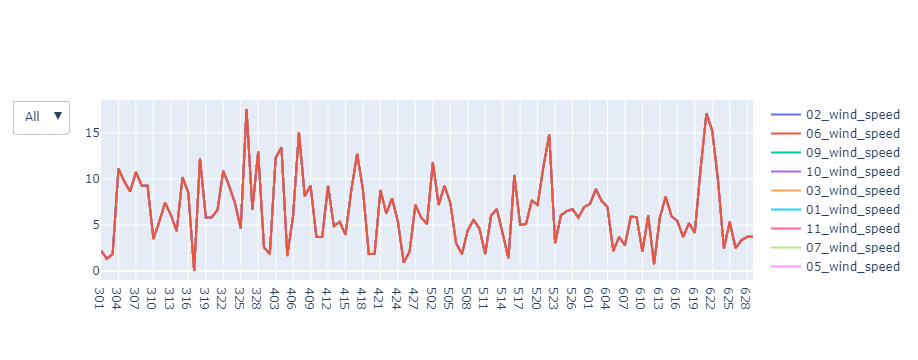

In [142]:
fig.show()

## Stock Transformer

Speaking of the time series analysis, the stock market must be the interest of most people. __Stock_Transformer__ makes our life easy and simple. Extraction of the stock data can be done in just one line of code, and we can also use the power of the data manipulation like how we did previously. 

Stock extraction methods:
- from_stock_engine_date
- from_stock_engine_period
- from_stock_engine_intraday


In [131]:
stock_data = Stock_Transformer.from_stock_engine_date(symbols = "aapl", 
                                                      "2019-01-01", "2022-05-26", "yahoo")
stock_data

data column
-----------
Date
Open
High
Low
Close
Volume
Dividends
Stock Splits
time length: 858
category: None


In [132]:
stock_data.to_pandas().head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-01-02,37.488016,38.446457,37.328276,38.221367,148158800,0.0,0.0
1,2019-01-03,34.847466,35.268599,34.368248,34.414234,365248800,0.0,0.0
2,2019-01-04,34.980580,35.953541,34.803899,35.883350,234428400,0.0,0.0
3,2019-01-07,35.989850,36.021315,35.312165,35.803486,219111200,0.0,0.0
4,2019-01-08,36.197995,36.744985,35.946286,36.486012,164101200,0.0,0.0


In [133]:
import pandas_ta as ta

MyStrategy = ta.Strategy(
    name="DCSMA10",
    ta=[
        {"kind": "macd"},
        {"kind": "ema", "length": 10},
        {"kind": "bbands", "length": 20, "col_names": ("BBL", "BBM", "BBU", "Bandwidth", "Percent")},
    ]
)

stock_data = stock_data.get_technial_indicator(MyStrategy)
print(stock_data.to_pandas()[25:30])

          Date       Open       High        Low      Close     Volume  \
25  2019-02-07  41.725962  42.098690  41.227381  41.372601  126966800   
26  2019-02-08  41.076051  41.481974  40.937501  41.421207   95280000   
27  2019-02-11  41.576775  41.615667  41.139252  41.183002   83973600   
28  2019-02-12  41.345854  41.564614  41.248625  41.537876   89134000   
29  2019-02-13  41.659413  41.924356  41.302103  41.365299   89960800   

    Dividends  Stock Splits  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  \
25     0.0000           0.0      1.952193            NaN            NaN   
26     0.1825           0.0      1.915505            NaN            NaN   
27     0.0000           0.0      1.845929            NaN            NaN   
28     0.0000           0.0      1.798691            NaN            NaN   
29     0.0000           0.0      1.727417            NaN            NaN   

       EMA_10        BBL        BBM        BBU  Bandwidth   Percent  
25  40.383502  34.842427  38.655327  42.

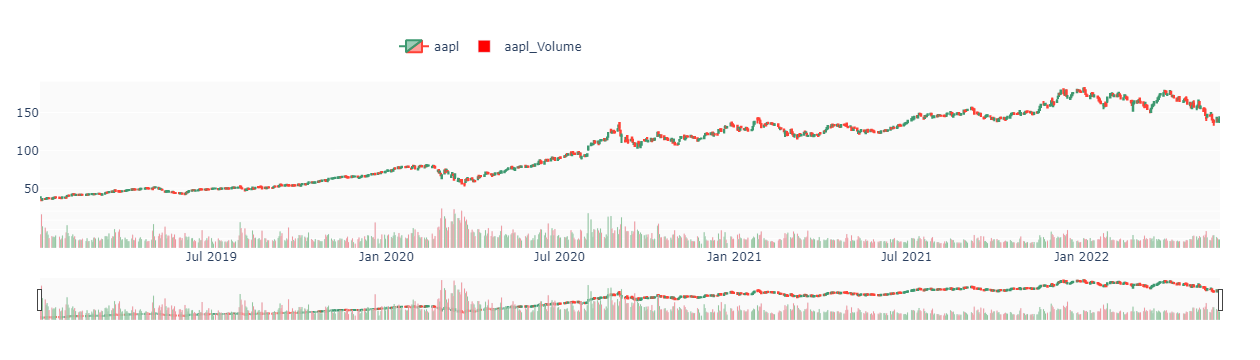

In [134]:
fig = stock_data.plot
fig.show()

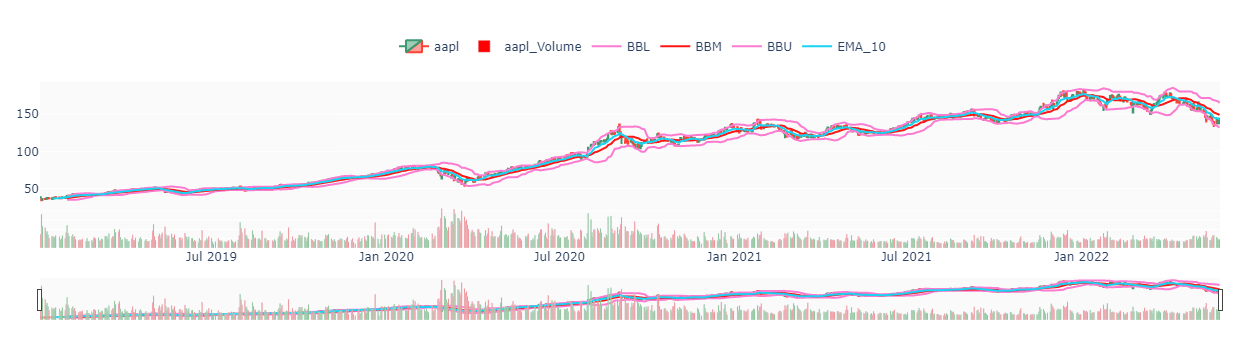

In [135]:
# Bollinger Band
fig.add_line(col = 'BBL', lineType = 'scatter', color = '#FC7BD1')
fig.add_line(col = 'BBM', lineType = 'scatter', color = '#FC1616')
fig.add_line(col = 'BBU', lineType = 'scatter', color = '#FC7BD1')

# EMA_10
fig.add_line(col = 'EMA_10', lineType = 'scatter')

fig.show()